In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import toml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc

import pyarrow.parquet as pq

sys.path.append("..")
from MLP_utils.utils import parameter_set
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)


sys.path.append("../..")
from utils.utils import df_stats

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../../Extracted_Features_(CSV_files)/SHSY5Y_preprocessed_df_sc_norm.parquet"
)

df = pq.read_table(file_path).to_pandas()

In [3]:
data = Path("../MLP_utils/config.toml")
config = toml.load(data)
params = Parameters()
params = parameter_set(params, config)

In [4]:
def test_loop(df, output_name):
    # Code snippet for metadata extraction by Jenna Tomkinson
    df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

    # define which columns are data and which are descriptive
    df_descriptive = df[df_metadata]
    df_values = df.drop(columns=df_metadata)
    # Creating label encoder
    le = preprocessing.LabelEncoder()
    # Converting strings into numbers
    df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"] = le.fit_transform(
        df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    )
    # split into X and Y where Y are the predictive column and x are the observable data
    df_values_X = df_values.drop(
        [
            "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
            "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
            "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        ],
        axis=1,
    )
    df_values_Y = df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    test_data = Dataset_formatter(
        torch.FloatTensor(df_values_X.values), torch.FloatTensor(df_values_Y.values)
    )

    params.IN_FEATURES = df_values_X.shape[1]
    print("Number of in features: ", params.IN_FEATURES)
    if params.MODEL_TYPE == "Regression":
        params.OUT_FEATURES = 1
    else:
        params.OUT_FEATURES = len(
            df_values["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )

    print("Number of out features: ", params.OUT_FEATURES)

    if params.OUT_FEATURES > 2:
        params.MODEL_TYPE = "Multi_Class"
    elif params.OUT_FEATURES == 2:
        params.OUT_FEATURES = params.OUT_FEATURES - 1
        params.MODEL_TYPE = "Binary_Classification"
    elif params.OUT_FEATURES == 1:
        params.MODEL_TYPE = "Regression"
    else:
        pass
    print(params.MODEL_TYPE)

    # convert data class into a dataloader to be compatible with pytorch
    test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1)
    model = optimized_model_create(params, params.MODEL_NAME)
    # calling the testing function and outputting list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        y_pred_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        y_pred_list, y_pred_prob_list = test_optimized_model(
            model, test_loader, params, model_name=params.MODEL_NAME
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

    # un-nest list if nested i.e. length of input data does not match length of output data
    if len(y_pred_list) != len(df_values_Y):
        y_pred_list = un_nest(y_pred_list)
        y_pred_prob_list = un_nest(y_pred_prob_list)
    else:
        pass
    # Call visualization function
    # calling the testing function and outputing list values of tested model
    if params.MODEL_TYPE == "Multi_Class" or params.MODEL_TYPE == "Regression":
        confusion_matrix_df = results_output(
            y_pred_list,
            df_values_Y,
            params,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
        )
    elif params.MODEL_TYPE == "Binary_Classification":
        results_output(
            y_pred_list,
            df_values_Y,
            params,
            y_pred_prob_list,
            test_name=f"{output_name}_all_testing",
            model_name=params.MODEL_NAME,
        )
    else:
        raise Exception("Model type must be specified for proper model testing")

In [5]:
df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()

array(['media ctr_0_Media ctr_0.0', 'DMSO_0.100_DMSO_1.0',
       'DMSO_0.100_Z-VAD-FMK_100.0', 'DMSO_0.100_Z-VAD-FMK_30.0',
       'DMSO_0.100_DMSO_0.025', 'Thapsigargin_1.000_DMSO_0.025',
       'Thapsigargin_10.000_DMSO_0.025', 'Topotecan_5.000_DMSO_0.025',
       'Topotecan_10.000_DMSO_0.025', 'Topotecan_20.000_DMSO_0.025',
       'LPS_0.010_DMSO_0.025', 'LPS_0.100_DMSO_0.025',
       'LPS_1.000_DMSO_0.025', 'LPS_10.000_DMSO_0.025',
       'LPS_10.000_Disulfiram_0.1', 'LPS_10.000_Disulfiram_1.0',
       'LPS_10.000_Disulfiram_2.5',
       'LPS_Nigericin_100.000_1.0_DMSO_0.025',
       'LPS_Nigericin_100.000_3.0_DMSO_0.025',
       'LPS_Nigericin_100.000_10.0_DMSO_0.025',
       'Disulfiram_0.100_DMSO_0.025', 'Disulfiram_1.000_DMSO_0.025',
       'Disulfiram_2.500_DMSO_0.025', 'H2O2_100.000_DMSO_0.025',
       'LPS_10.000_Z-VAD-FMK_100.0', 'LPS_100.000_DMSO_0.025',
       'LPS_Nigericin_1.000_1.0_DMSO_0.025',
       'LPS_Nigericin_1.000_3.0_DMSO_0.025',
       'LPS_Nigericin_1.000_1

media ctr_0_Media ctr_0.0_H2O2_100.000_DMSO_0.025_LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.49      0.83      0.62     26900
           1       0.92      0.94      0.93     15987
           2       0.24      0.05      0.08     23925

    accuracy                           0.58     66812
   macro avg       0.55      0.61      0.54     66812
weighted avg       0.50      0.58      0.50     66812

Precision for class 0: 0.4909314749269022
Recall for class 0: 0.8301486988847584
Precision for class 1: 0.9209333659970602
Recall for class 1: 0.9405767185838494
Precision for class 2: 0.2423454072443466
Recall for class 2: 0.05061650992685476
3


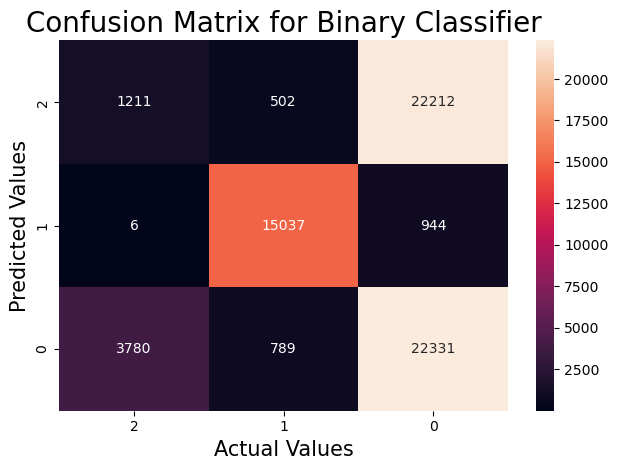

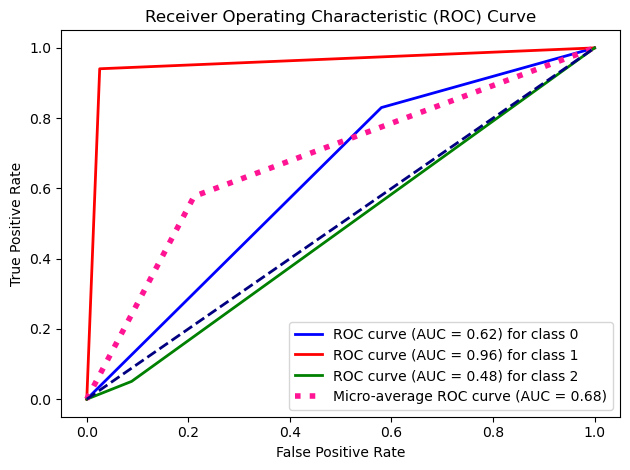

DMSO_0.100_DMSO_1.0_H2O2_100.000_DMSO_0.025_LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class
              precision    recall  f1-score   support

           0       0.39      0.93      0.54     15782
           1       0.05      0.03      0.04     26900
           2       0.00      0.00      0.00     15987

    accuracy                           0.26     58669
   macro avg       0.15      0.32      0.19     58669
weighted avg       0.13      0.26      0.16     58669

Precision for class 0: 0.3858839050131926
Recall for class 0: 0.9266886326194399
Precision for class 1: 0.04858374384236454
Recall for class 1: 0.02933085501858736
Precision for class 2: 0.0013247957606535659
Recall for class 2: 0.0003753049352598987
3


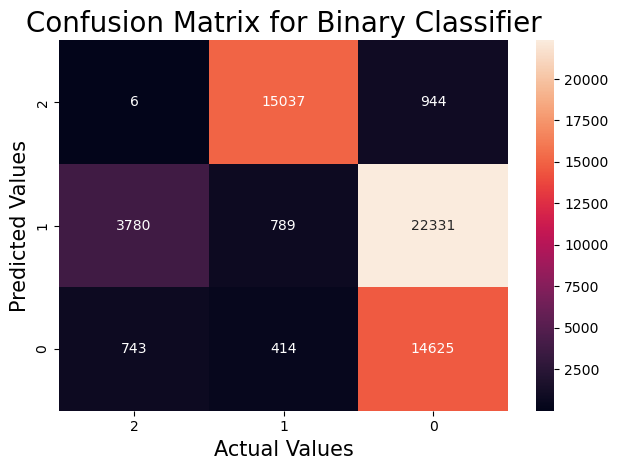

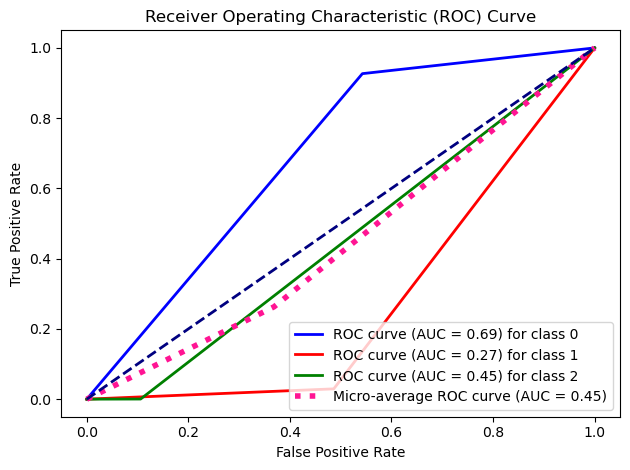

DMSO_0.100_Z-VAD-FMK_100.0_H2O2_100.000_DMSO_0.025_LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  3
Multi_Class


KeyboardInterrupt: 

In [6]:
for i in df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique():
    if i == "LPS_100.000_DMSO_0.025":
        pass
    else:
        test_df = df.query(
            f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_DMSO_0.025' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_DMSO_0.025' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}'"
        )
        output_name = ("_").join(
            test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )
        print(output_name)
        test_loop(test_df, output_name)

media ctr_0_Media ctr_0.0_DMSO_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.60      0.99      0.75     35643
           1       0.61      0.01      0.03     23925

    accuracy                           0.60     59568
   macro avg       0.61      0.50      0.39     59568
weighted avg       0.61      0.60      0.46     59568



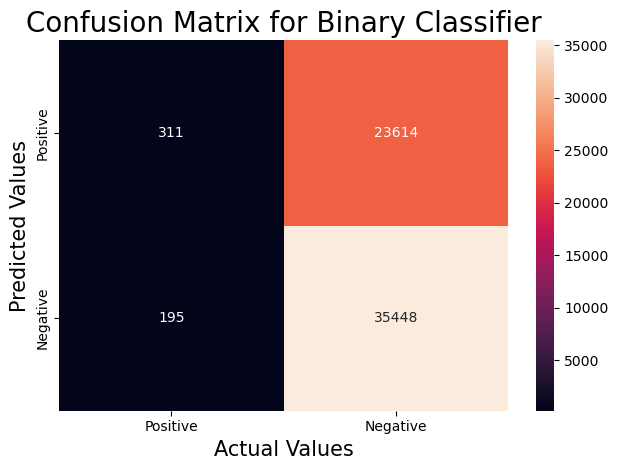

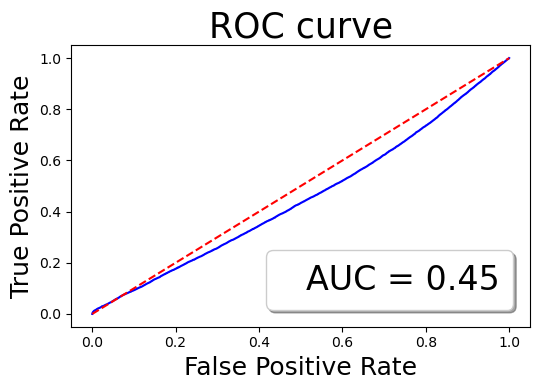

DMSO_0.100_DMSO_1.0_DMSO_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.69      0.99      0.82     35643
           1       0.47      0.01      0.02     15782

    accuracy                           0.69     51425
   macro avg       0.58      0.50      0.42     51425
weighted avg       0.63      0.69      0.57     51425



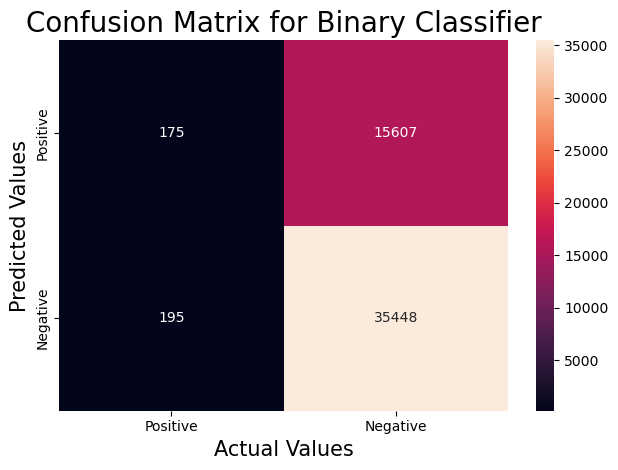

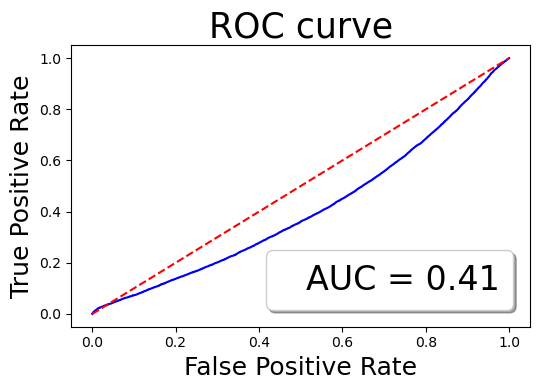

DMSO_0.100_Z-VAD-FMK_100.0_DMSO_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     35643
           1       0.49      0.01      0.02     16724

    accuracy                           0.68     52367
   macro avg       0.59      0.50      0.42     52367
weighted avg       0.62      0.68      0.56     52367



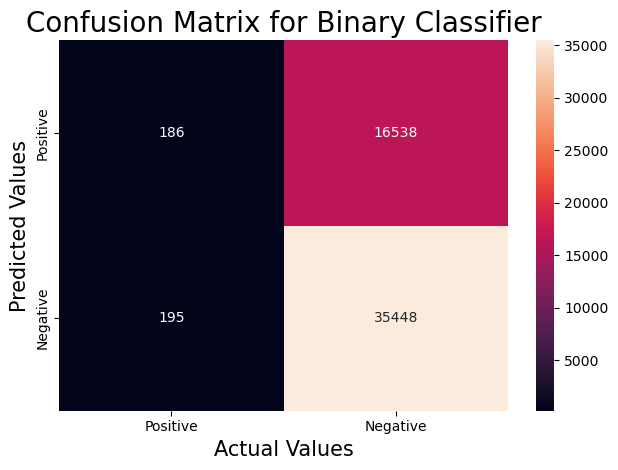

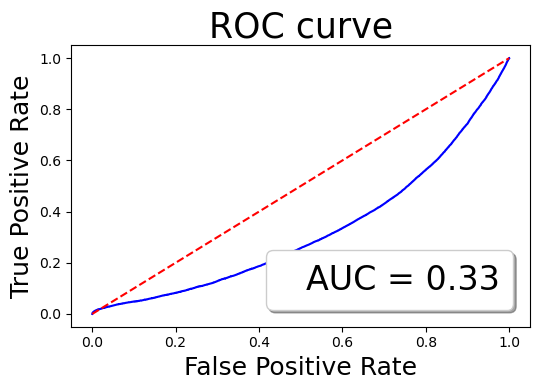

DMSO_0.100_Z-VAD-FMK_30.0_DMSO_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     35643
           1       0.52      0.01      0.02     16455

    accuracy                           0.68     52098
   macro avg       0.60      0.50      0.42     52098
weighted avg       0.63      0.68      0.56     52098



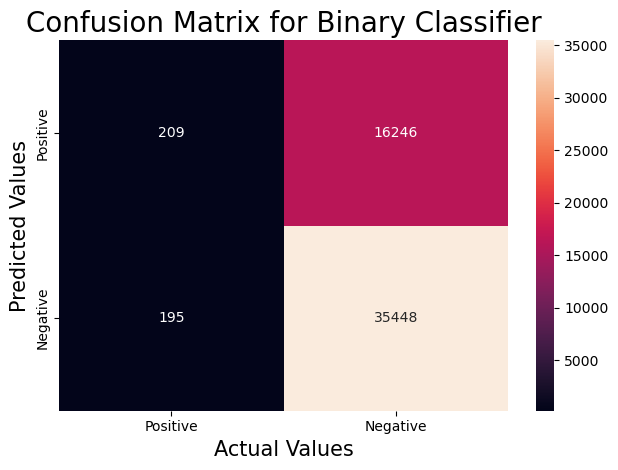

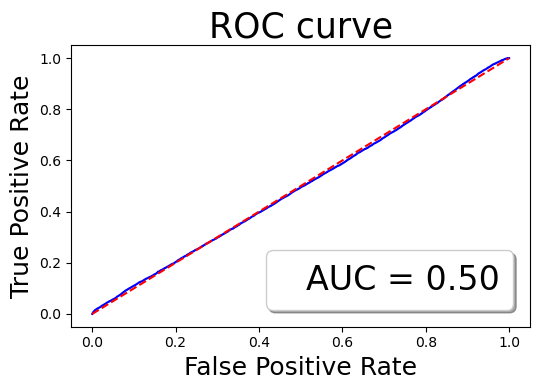

DMSO_0.100_DMSO_0.025_Thapsigargin_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.72      0.99      0.84     35643
           1       0.58      0.02      0.04     13766

    accuracy                           0.72     49409
   macro avg       0.65      0.51      0.44     49409
weighted avg       0.68      0.72      0.62     49409



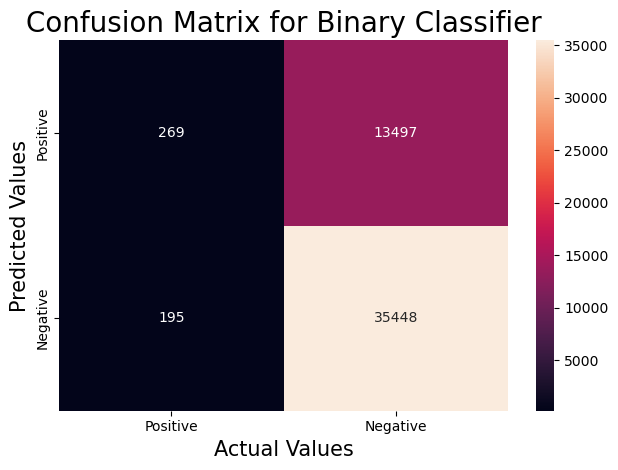

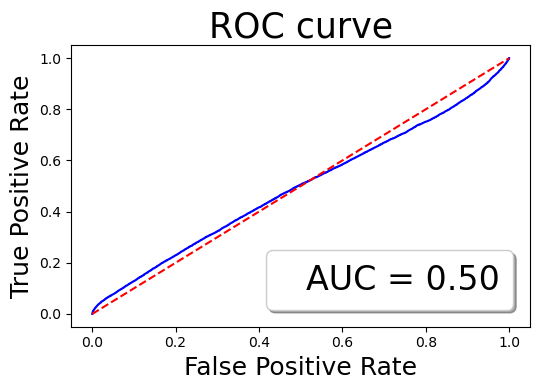

DMSO_0.100_DMSO_0.025_Thapsigargin_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.73      0.99      0.84     35643
           1       0.50      0.01      0.03     13212

    accuracy                           0.73     48855
   macro avg       0.62      0.50      0.44     48855
weighted avg       0.67      0.73      0.62     48855



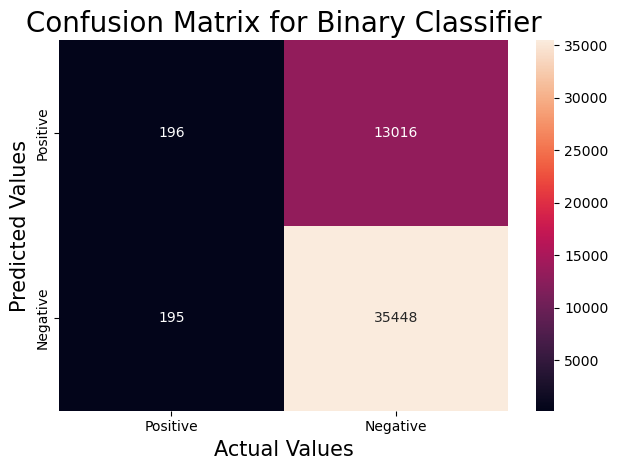

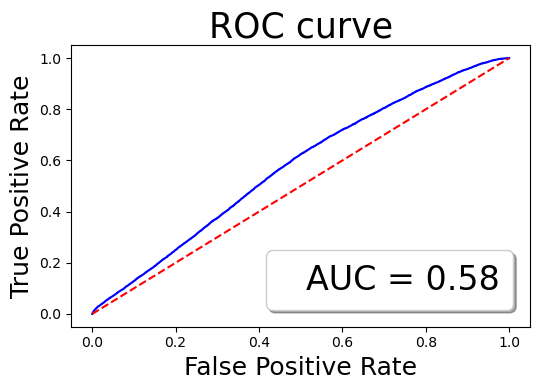

DMSO_0.100_DMSO_0.025_Topotecan_5.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     35643
           1       0.81      0.05      0.09     17508

    accuracy                           0.68     53151
   macro avg       0.75      0.52      0.45     53151
weighted avg       0.72      0.68      0.57     53151



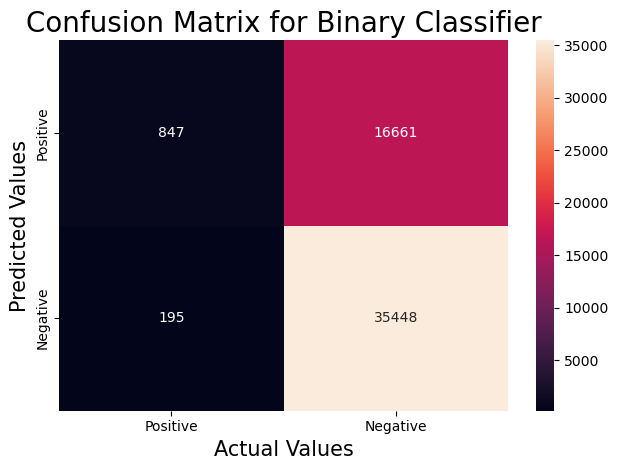

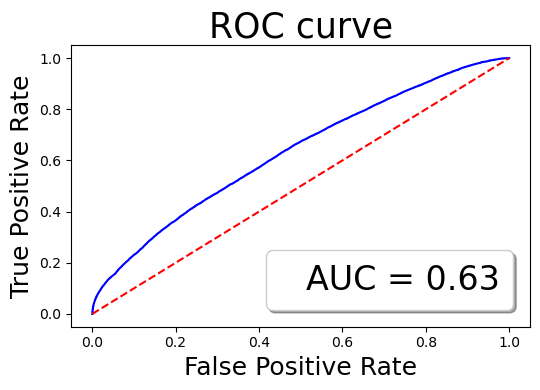

DMSO_0.100_DMSO_0.025_Topotecan_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     35643
           1       0.46      0.01      0.02     17081

    accuracy                           0.68     52724
   macro avg       0.57      0.50      0.41     52724
weighted avg       0.61      0.68      0.55     52724



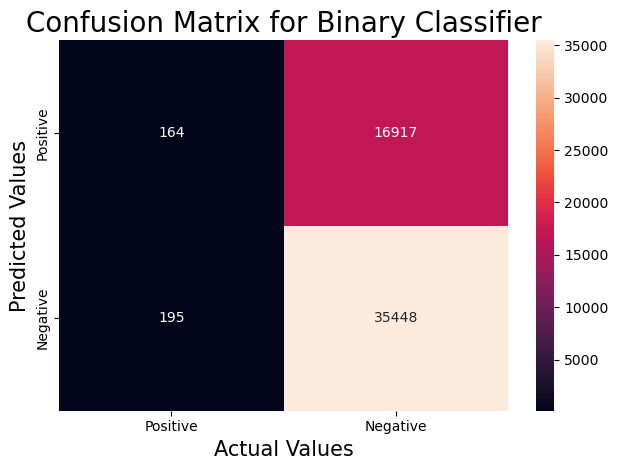

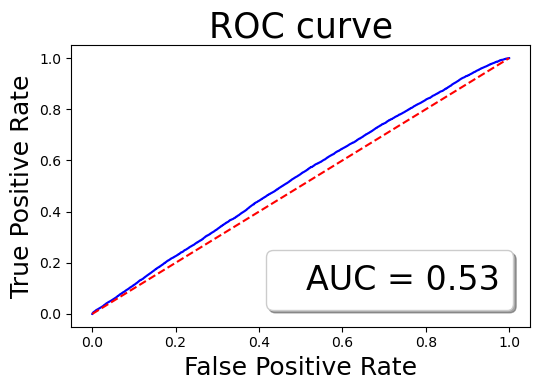

DMSO_0.100_DMSO_0.025_Topotecan_20.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.67      0.99      0.80     35643
           1       0.35      0.01      0.01     17954

    accuracy                           0.66     53597
   macro avg       0.51      0.50      0.40     53597
weighted avg       0.56      0.66      0.53     53597



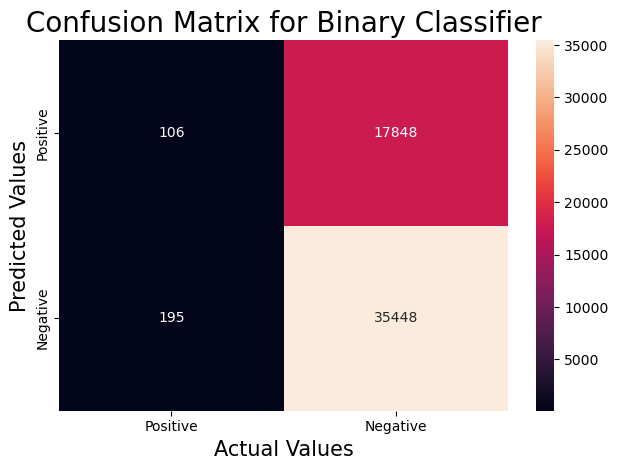

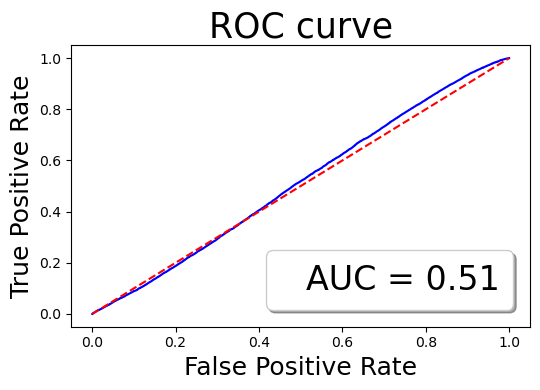

DMSO_0.100_DMSO_0.025_LPS_0.010_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.69      0.99      0.82     35643
           1       0.41      0.01      0.02     15859

    accuracy                           0.69     51502
   macro avg       0.55      0.50      0.42     51502
weighted avg       0.61      0.69      0.57     51502



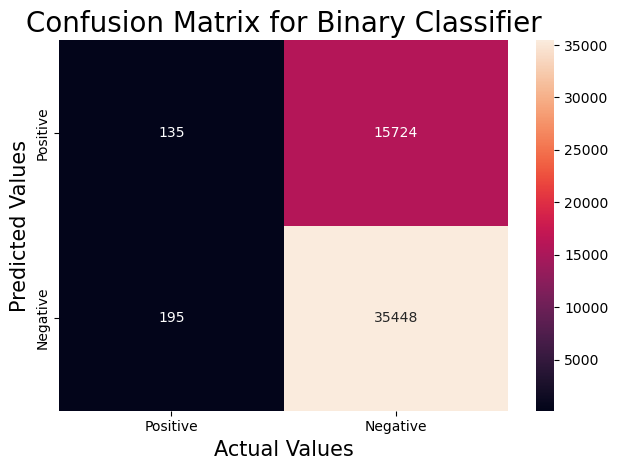

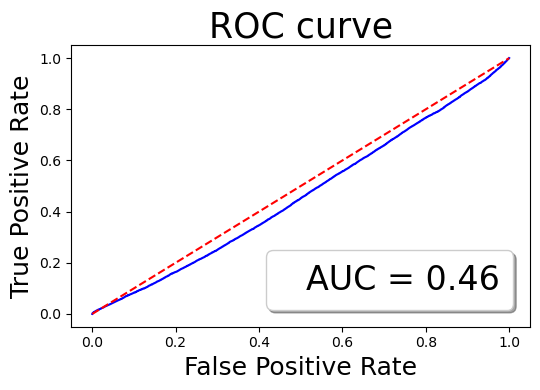

DMSO_0.100_DMSO_0.025_LPS_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     35643
           1       0.75      0.03      0.07     17510

    accuracy                           0.68     53153
   macro avg       0.72      0.51      0.44     53153
weighted avg       0.70      0.68      0.56     53153



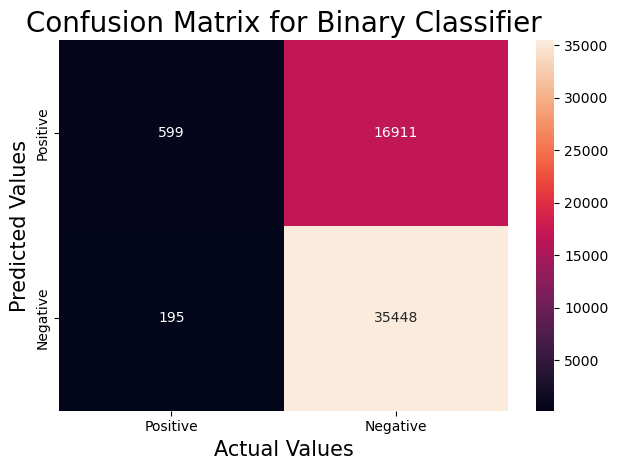

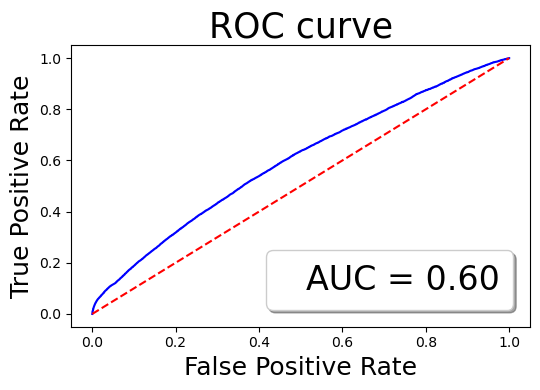

DMSO_0.100_DMSO_0.025_LPS_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     35643
           1       0.74      0.03      0.06     16458

    accuracy                           0.69     52101
   macro avg       0.71      0.51      0.44     52101
weighted avg       0.71      0.69      0.58     52101



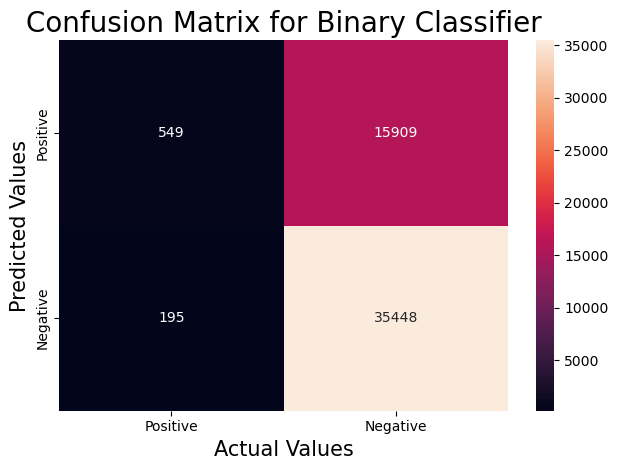

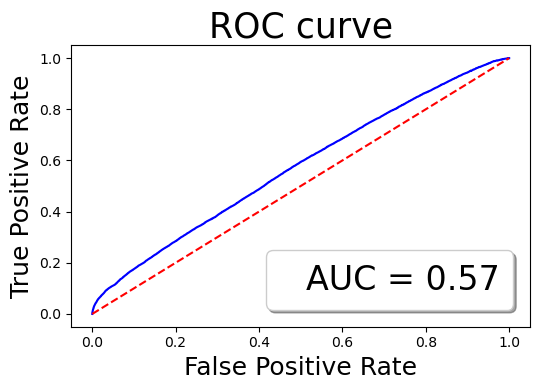

DMSO_0.100_DMSO_0.025_LPS_10.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     35643
           1       0.76      0.04      0.07     16810

    accuracy                           0.69     52453
   macro avg       0.72      0.52      0.44     52453
weighted avg       0.71      0.69      0.57     52453



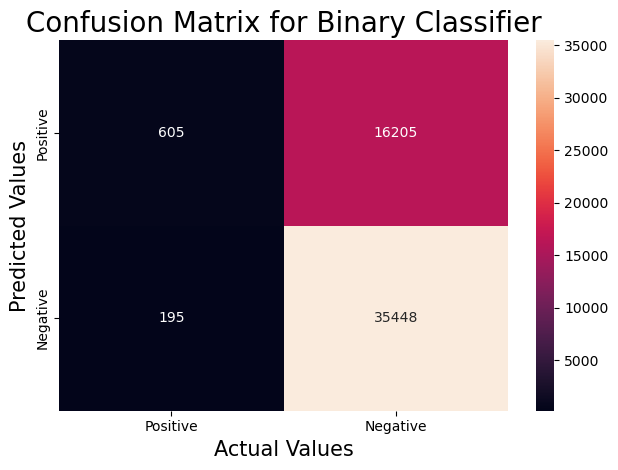

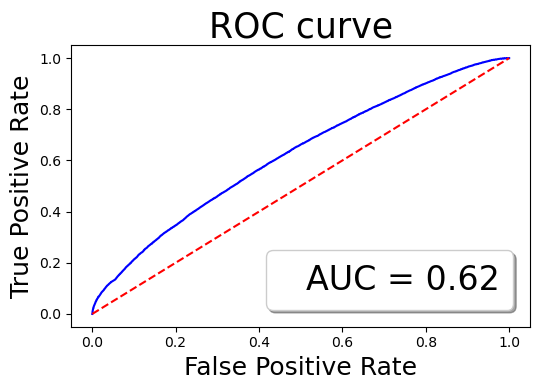

DMSO_0.100_DMSO_0.025_LPS_10.000_Disulfiram_0.1
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.71      0.99      0.83     35643
           1       0.90      0.10      0.19     16316

    accuracy                           0.71     51959
   macro avg       0.80      0.55      0.51     51959
weighted avg       0.77      0.71      0.63     51959



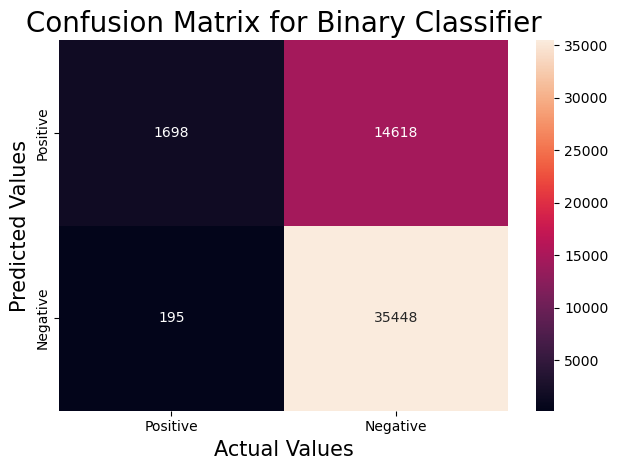

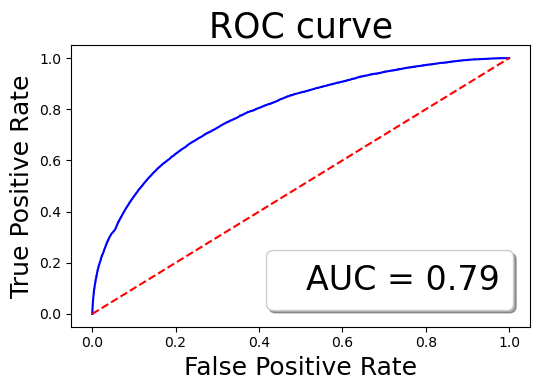

DMSO_0.100_DMSO_0.025_LPS_10.000_Disulfiram_1.0
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.70      0.99      0.82     35643
           1       0.78      0.04      0.08     16167

    accuracy                           0.70     51810
   macro avg       0.74      0.52      0.45     51810
weighted avg       0.72      0.70      0.59     51810



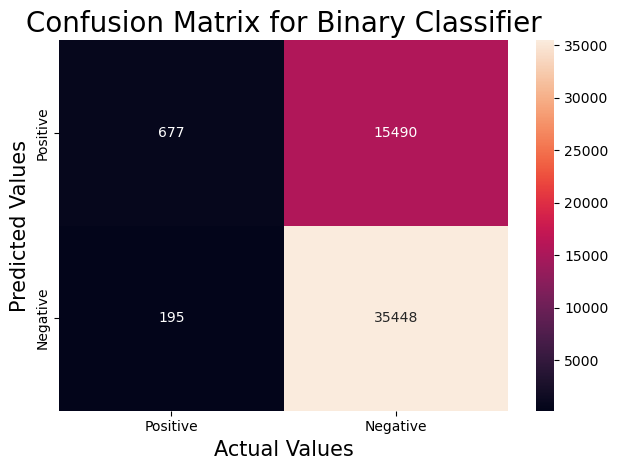

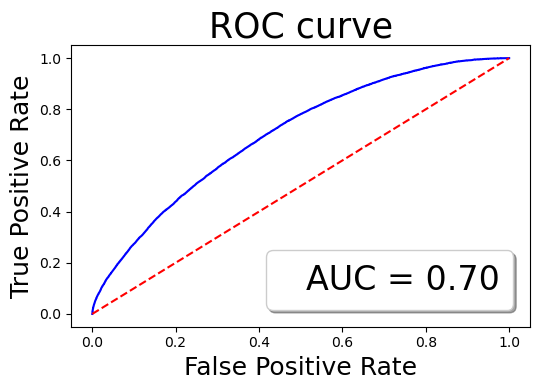

DMSO_0.100_DMSO_0.025_LPS_10.000_Disulfiram_2.5
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.72      0.99      0.83     35643
           1       0.81      0.06      0.10     14644

    accuracy                           0.72     50287
   macro avg       0.76      0.52      0.47     50287
weighted avg       0.74      0.72      0.62     50287



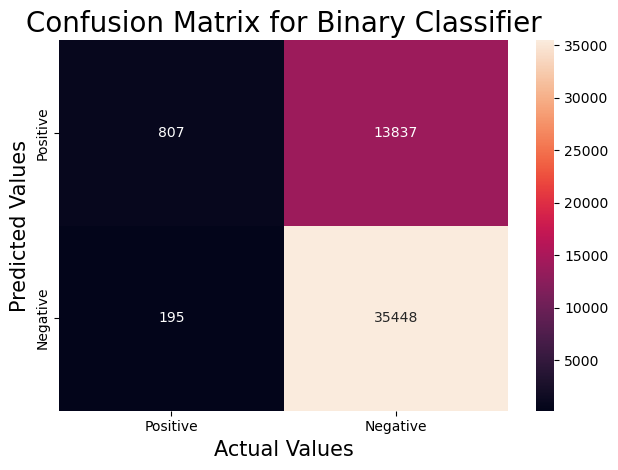

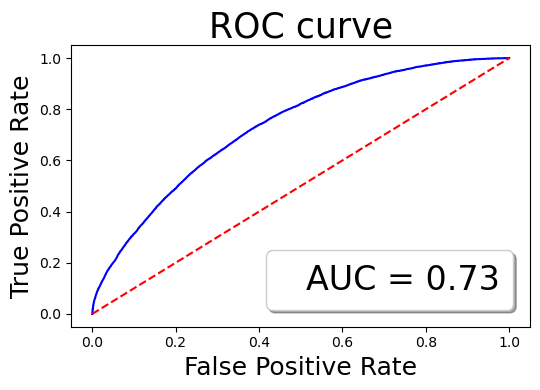

DMSO_0.100_DMSO_0.025_LPS_Nigericin_100.000_1.0_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     35643
           1       0.98      0.70      0.82     14690

    accuracy                           0.91     50333
   macro avg       0.94      0.85      0.88     50333
weighted avg       0.92      0.91      0.90     50333



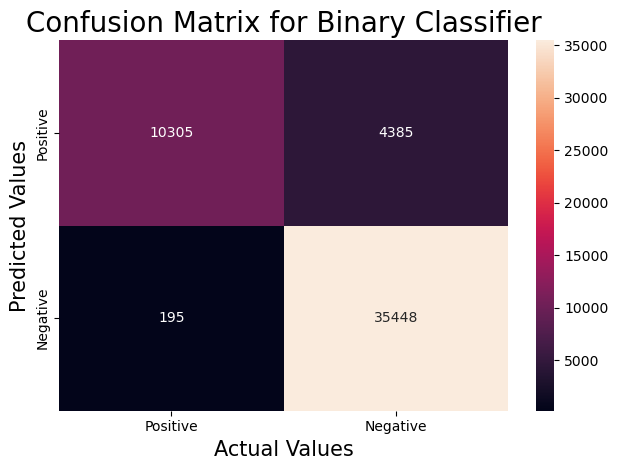

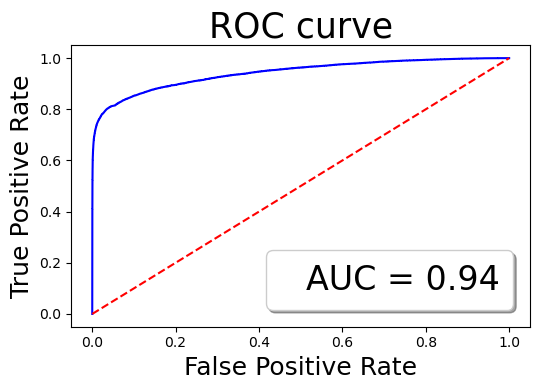

DMSO_0.100_DMSO_0.025_LPS_Nigericin_100.000_3.0_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     35643
           1       0.99      0.87      0.92     16726

    accuracy                           0.95     52369
   macro avg       0.96      0.93      0.94     52369
weighted avg       0.96      0.95      0.95     52369



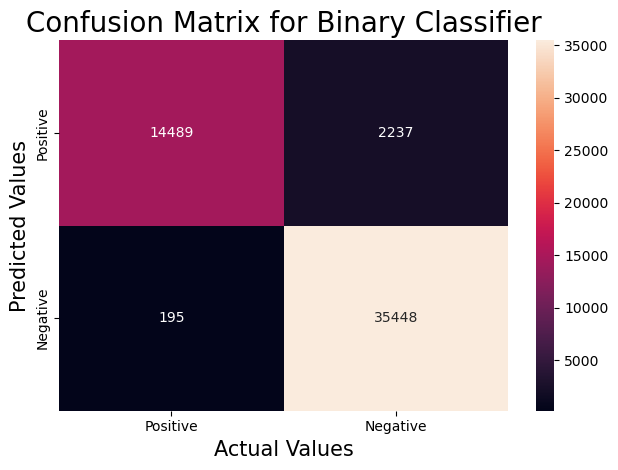

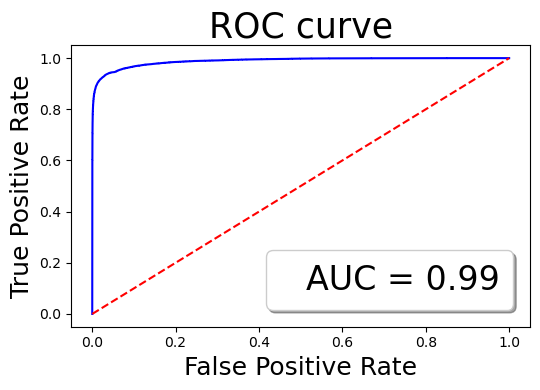

DMSO_0.100_DMSO_0.025_LPS_Nigericin_100.000_10.0_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     35643
           1       0.99      0.96      0.97     13677

    accuracy                           0.98     49320
   macro avg       0.98      0.98      0.98     49320
weighted avg       0.98      0.98      0.98     49320



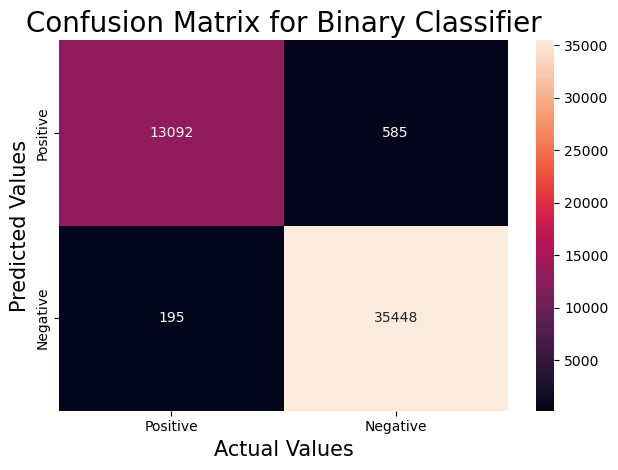

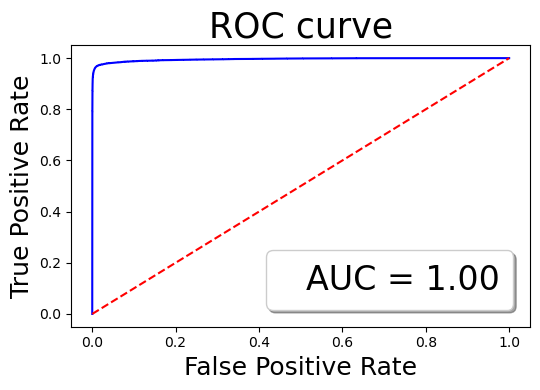

DMSO_0.100_DMSO_0.025_Disulfiram_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.70      0.99      0.82     35643
           1       0.82      0.06      0.11     15978

    accuracy                           0.70     51621
   macro avg       0.76      0.53      0.47     51621
weighted avg       0.74      0.70      0.60     51621



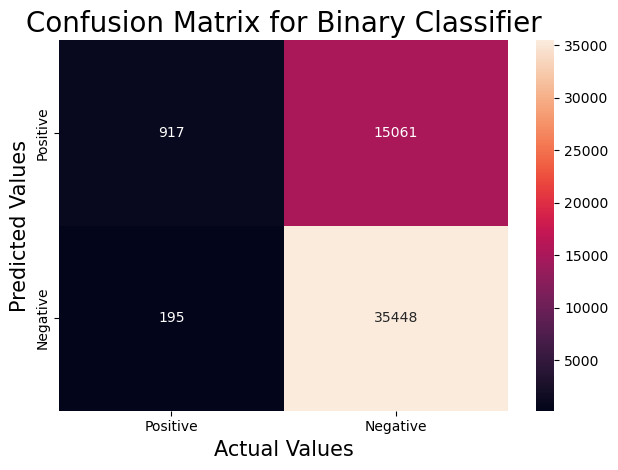

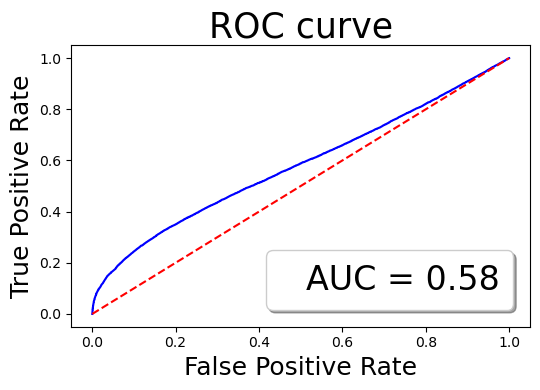

DMSO_0.100_DMSO_0.025_Disulfiram_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     35643
           1       0.74      0.03      0.06     16510

    accuracy                           0.69     52153
   macro avg       0.71      0.51      0.44     52153
weighted avg       0.70      0.69      0.58     52153



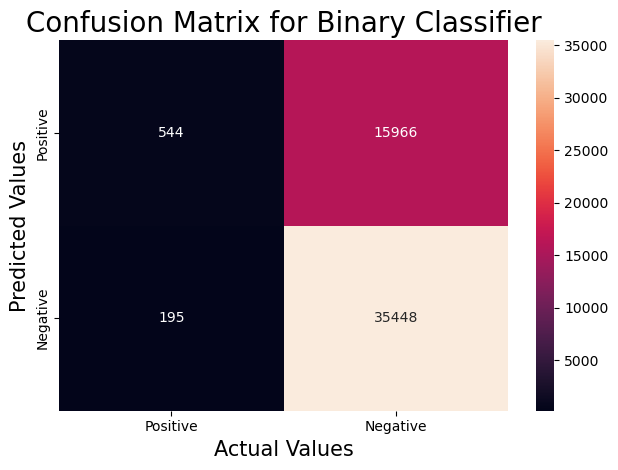

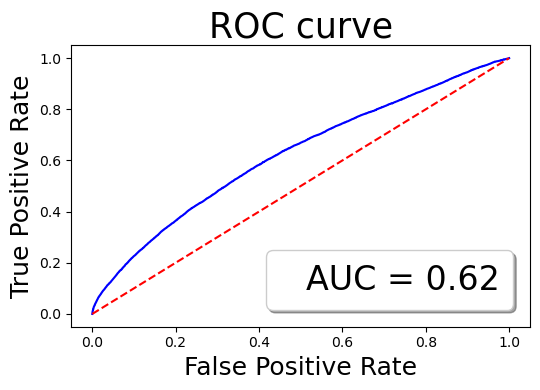

DMSO_0.100_DMSO_0.025_Disulfiram_2.500_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.67      0.99      0.80     35643
           1       0.56      0.01      0.03     17606

    accuracy                           0.67     53249
   macro avg       0.62      0.50      0.41     53249
weighted avg       0.63      0.67      0.55     53249



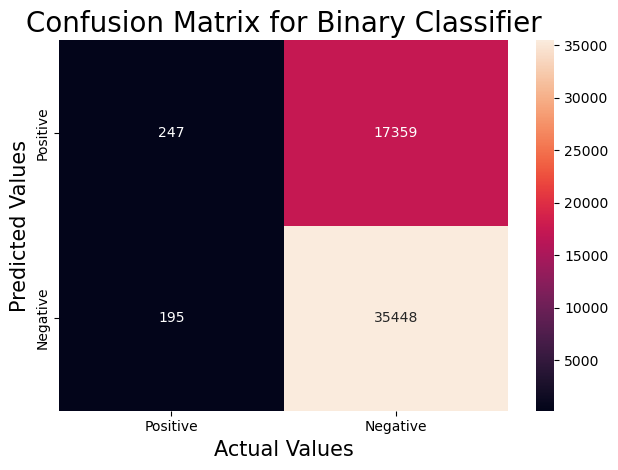

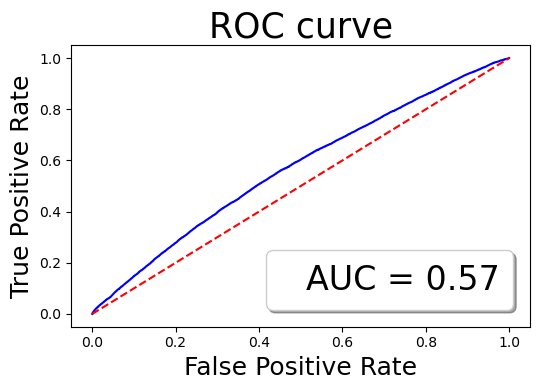

DMSO_0.100_DMSO_0.025_H2O2_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.58      0.99      0.73     35643
           1       0.80      0.03      0.06     26900

    accuracy                           0.58     62543
   macro avg       0.69      0.51      0.39     62543
weighted avg       0.67      0.58      0.44     62543



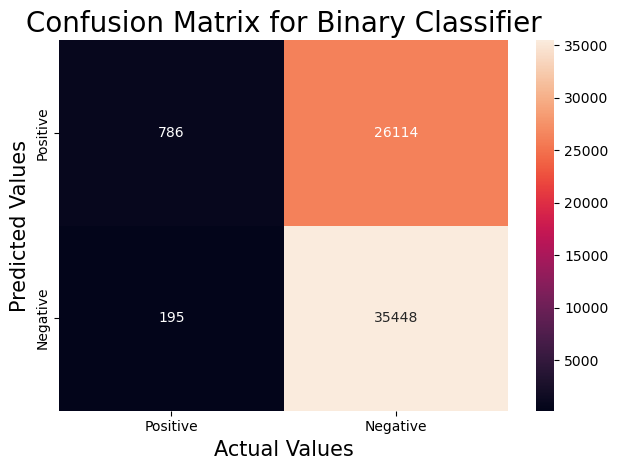

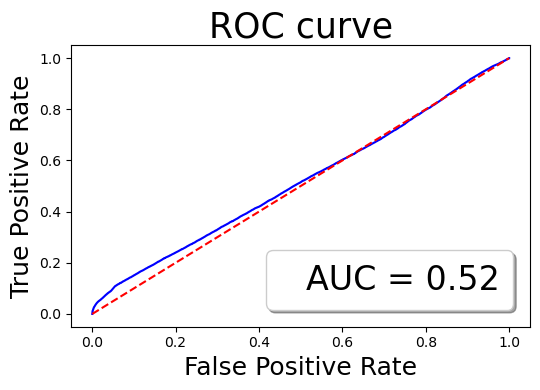

DMSO_0.100_DMSO_0.025_LPS_10.000_Z-VAD-FMK_100.0
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.69      0.99      0.81     35643
           1       0.72      0.03      0.06     16743

    accuracy                           0.69     52386
   macro avg       0.70      0.51      0.43     52386
weighted avg       0.70      0.69      0.57     52386



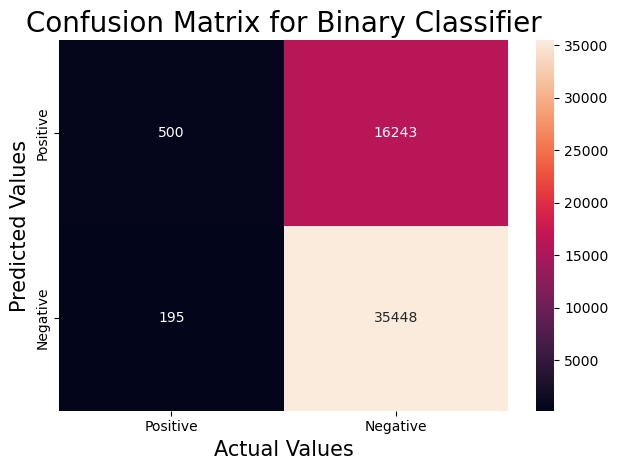

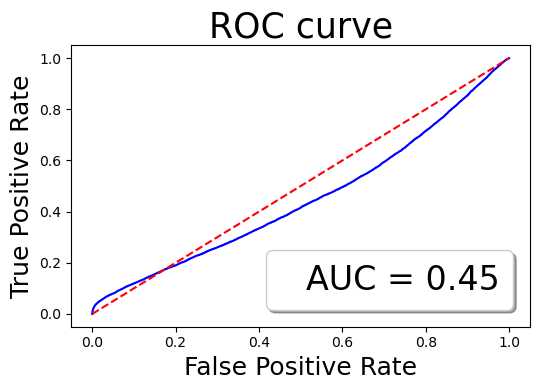

DMSO_0.100_DMSO_0.025_LPS_100.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     35643
           1       0.99      0.95      0.97     15987

    accuracy                           0.98     51630
   macro avg       0.98      0.97      0.98     51630
weighted avg       0.98      0.98      0.98     51630



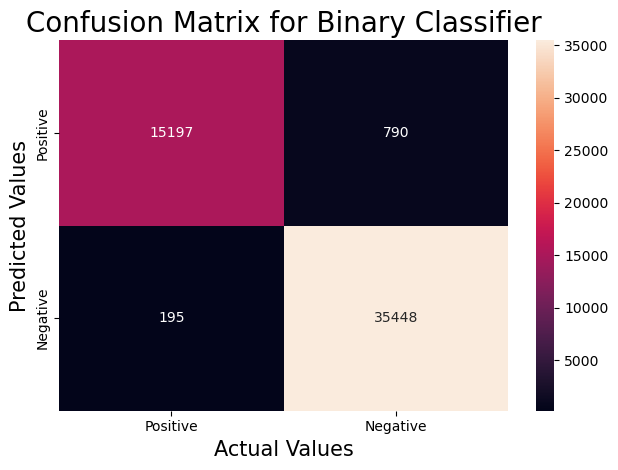

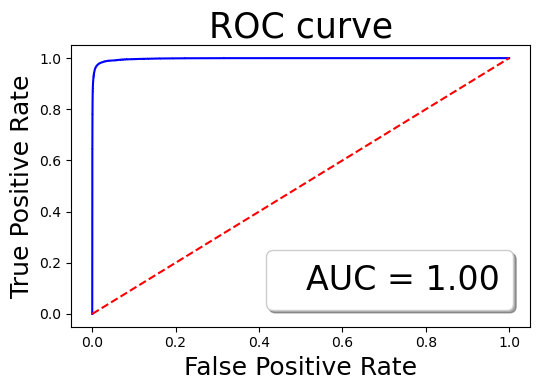

DMSO_0.100_DMSO_0.025_LPS_Nigericin_1.000_1.0_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.73      0.99      0.84     35643
           1       0.94      0.17      0.29     16218

    accuracy                           0.74     51861
   macro avg       0.83      0.58      0.57     51861
weighted avg       0.79      0.74      0.67     51861



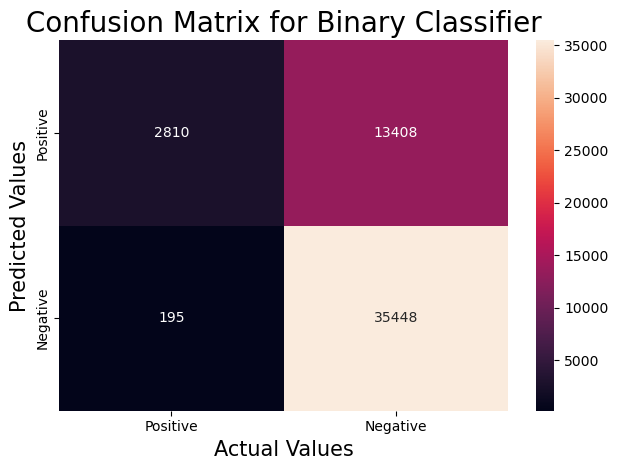

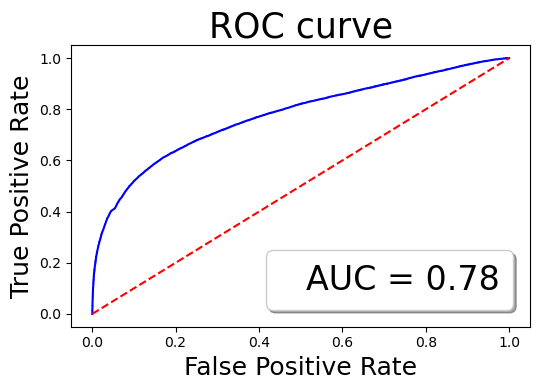

DMSO_0.100_DMSO_0.025_LPS_Nigericin_1.000_3.0_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     35643
           1       0.98      0.64      0.78     13652

    accuracy                           0.90     49295
   macro avg       0.93      0.82      0.85     49295
weighted avg       0.91      0.90      0.89     49295



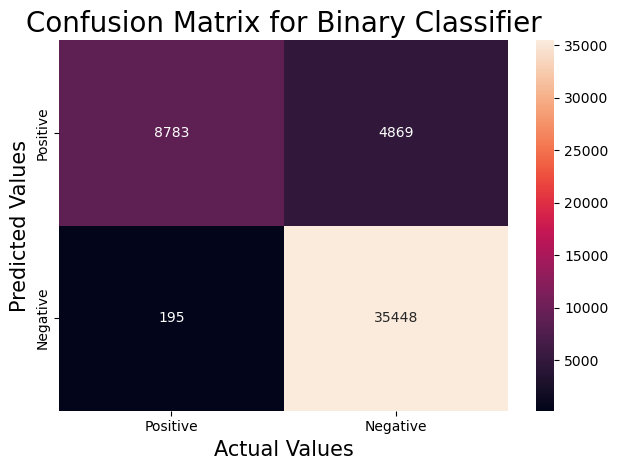

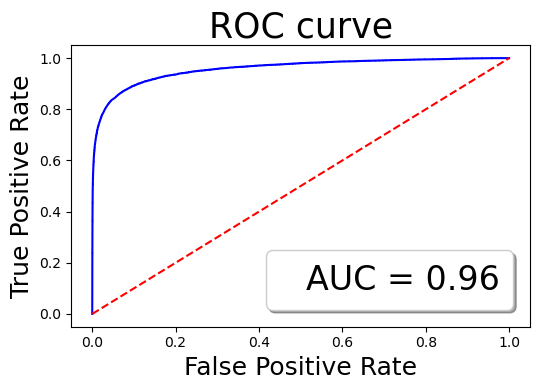

DMSO_0.100_DMSO_0.025_LPS_Nigericin_1.000_10.0_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     35643
           1       0.97      0.41      0.57     14402

    accuracy                           0.83     50045
   macro avg       0.89      0.70      0.73     50045
weighted avg       0.85      0.83      0.80     50045



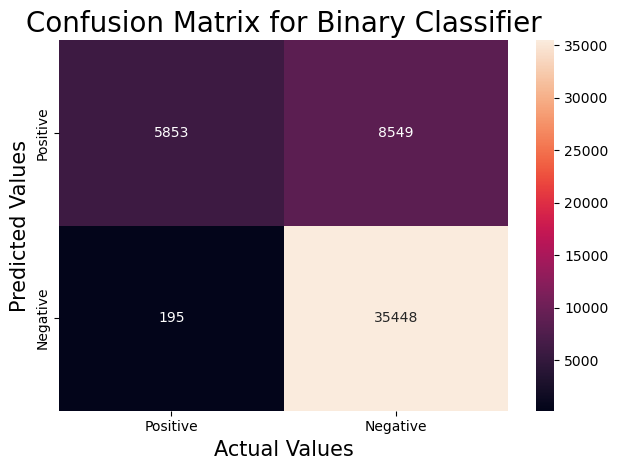

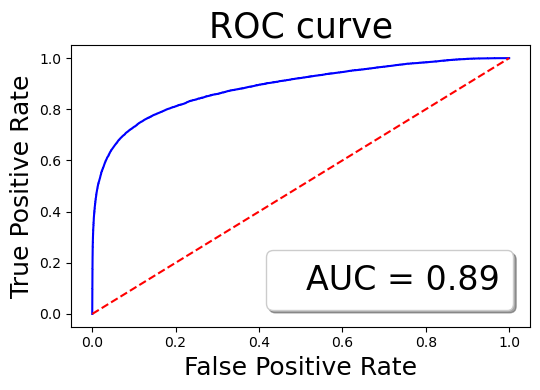

DMSO_0.100_DMSO_0.025_LPS_Nigericin_1.000_10.0_Disulfiram_1.0
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     35643
           1       0.96      0.35      0.52     12413

    accuracy                           0.83     48056
   macro avg       0.89      0.67      0.71     48056
weighted avg       0.85      0.83      0.80     48056



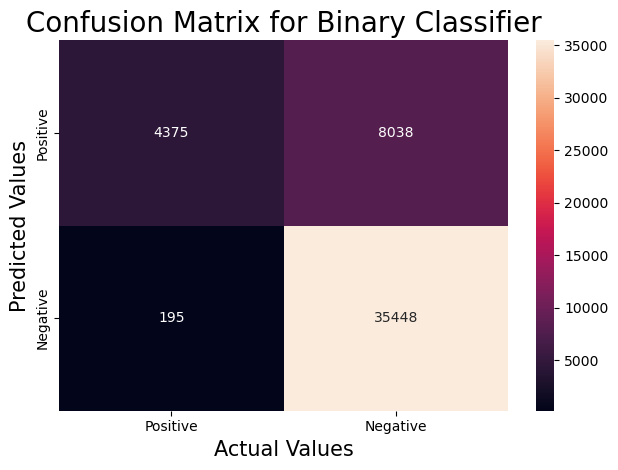

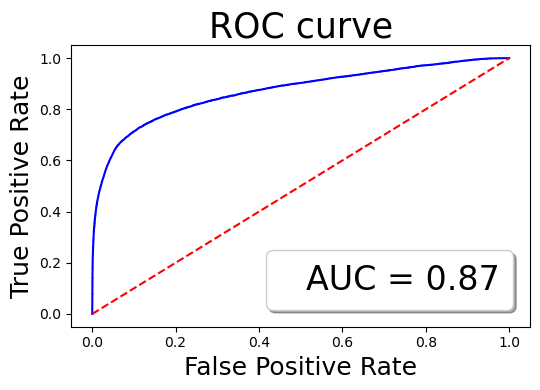

DMSO_0.100_DMSO_0.025_LPS_Nigericin_1.000_10.0_Z-VAD-FMK_100.0
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.72      0.99      0.84     35643
           1       0.79      0.05      0.09     14456

    accuracy                           0.72     50099
   macro avg       0.75      0.52      0.46     50099
weighted avg       0.74      0.72      0.62     50099



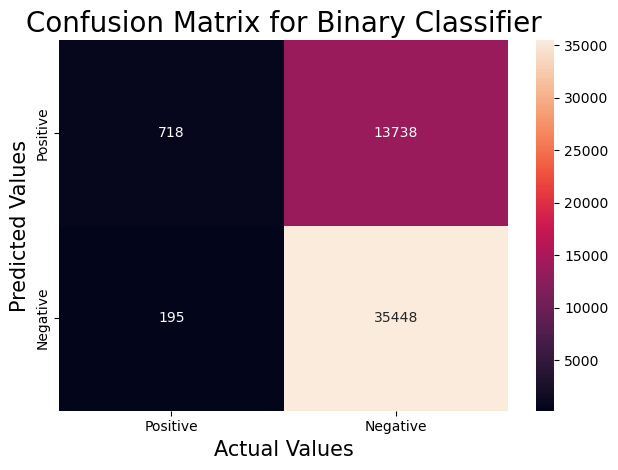

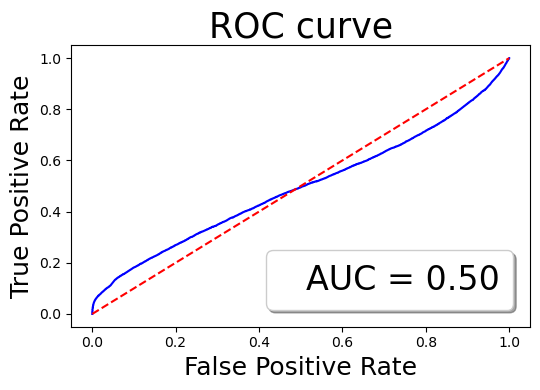

DMSO_0.100_DMSO_0.025_H2O2_100.000_Disulfiram_1.0
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     35643
           1       0.95      0.29      0.45     11761

    accuracy                           0.82     47404
   macro avg       0.88      0.64      0.67     47404
weighted avg       0.84      0.82      0.78     47404



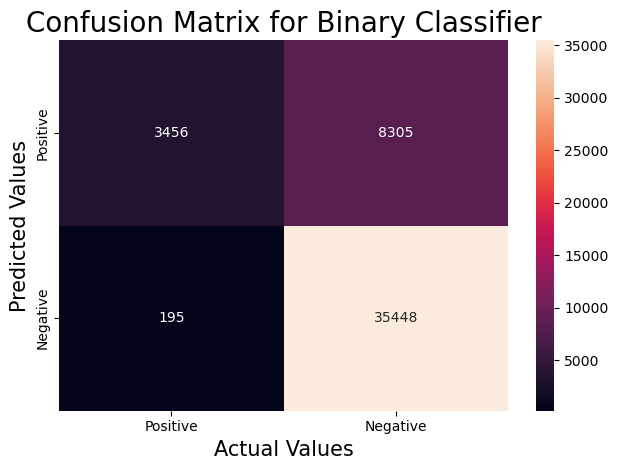

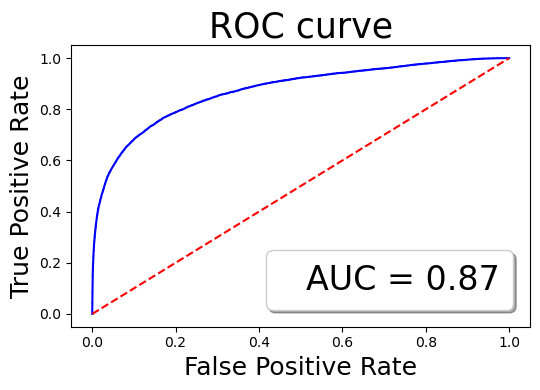

DMSO_0.100_DMSO_0.025_H2O2_100.000_Z-VAD-FMK_100.0
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.71      0.99      0.83     35643
           1       0.38      0.01      0.02     14747

    accuracy                           0.71     50390
   macro avg       0.55      0.50      0.42     50390
weighted avg       0.61      0.71      0.59     50390



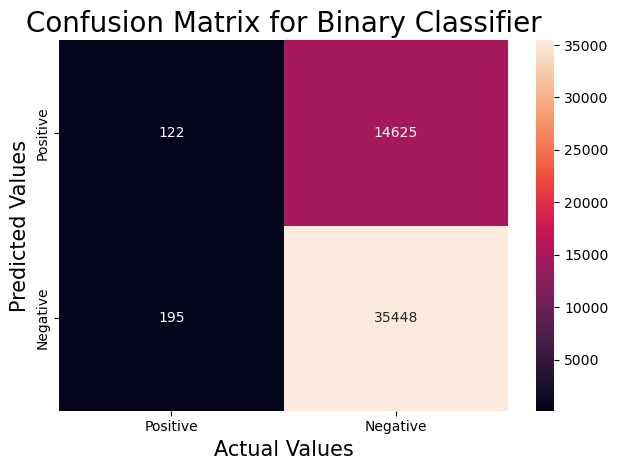

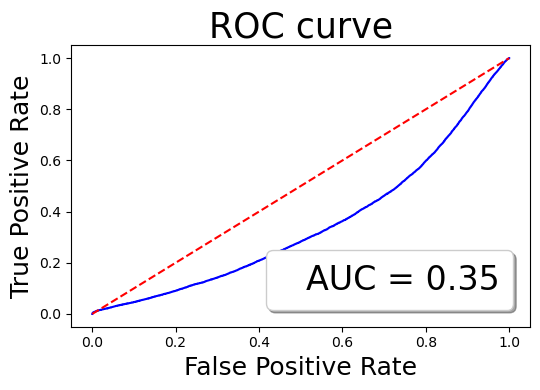

DMSO_0.100_DMSO_0.025_Flagellin_0.100_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.71      0.99      0.83     35643
           1       0.60      0.02      0.04     14928

    accuracy                           0.71     50571
   macro avg       0.66      0.51      0.43     50571
weighted avg       0.68      0.71      0.59     50571



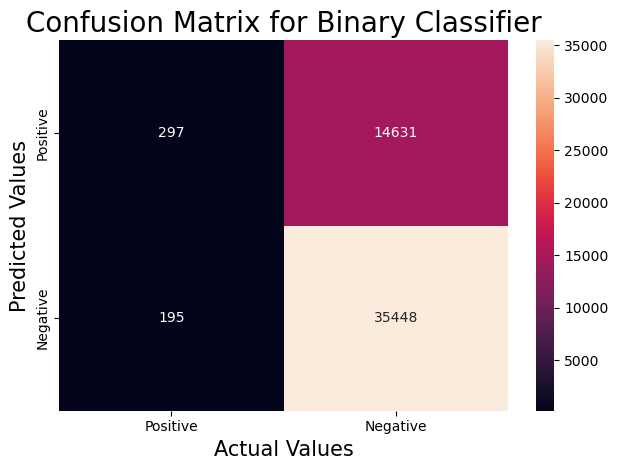

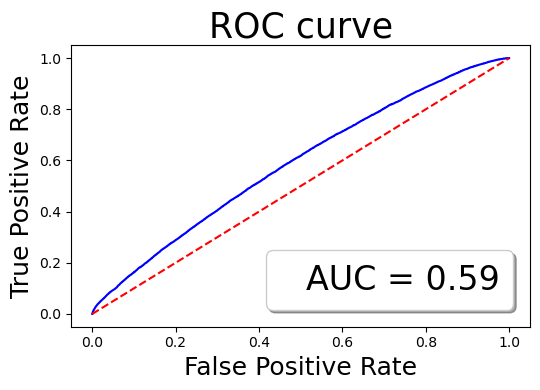

DMSO_0.100_DMSO_0.025_Flagellin_1.000_DMSO_0.025
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.70      0.99      0.82     35643
           1       0.81      0.05      0.10     15809

    accuracy                           0.70     51452
   macro avg       0.76      0.52      0.46     51452
weighted avg       0.74      0.70      0.60     51452



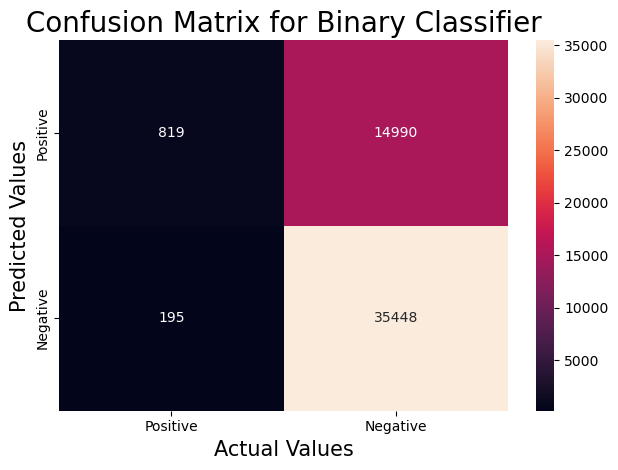

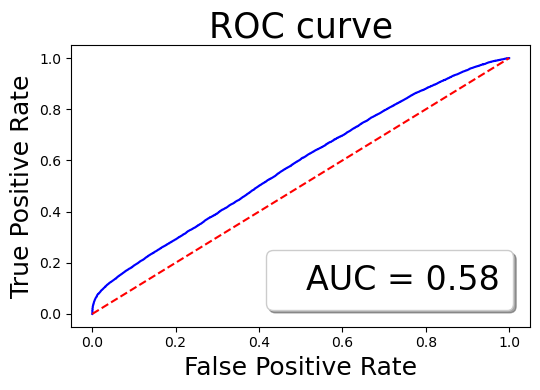

DMSO_0.100_DMSO_0.025_Flagellin_1.000_Disulfiram_1.0
Number of in features:  2847
Number of out features:  2
Binary_Classification
              precision    recall  f1-score   support

           0       0.74      0.99      0.85     35643
           1       0.40      0.01      0.02     12885

    accuracy                           0.73     48528
   macro avg       0.57      0.50      0.43     48528
weighted avg       0.65      0.73      0.63     48528



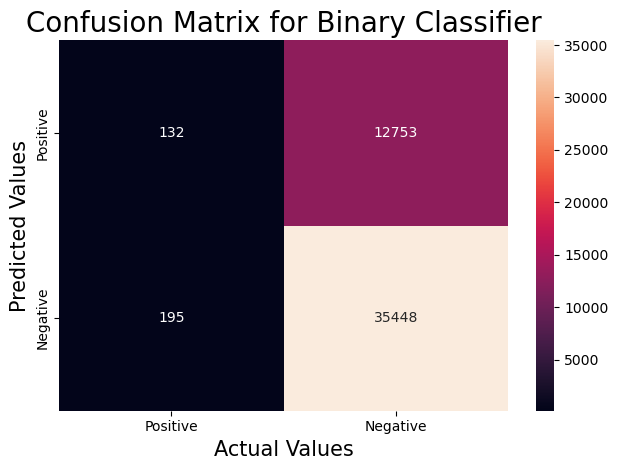

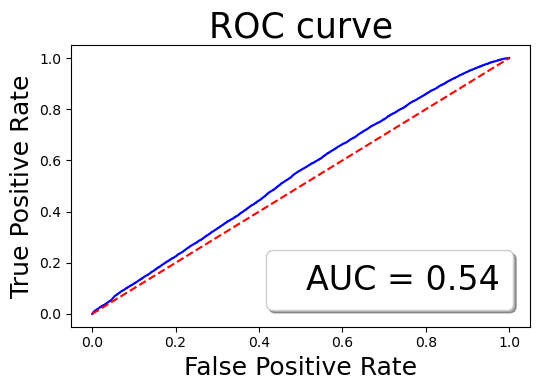

In [8]:
for i in df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique():
    if i == "DMSO_0.100_DMSO_0.025":
        pass
    else:
        test_df = df.query(
            f"oneb_Metadata_Treatment_Dose_Inhibitor_Dose == '{i}' | oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_DMSO_0.025'"
        )
        output_name = ("_").join(
            test_df["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"].unique()
        )
        print(output_name)
        test_loop(test_df, output_name)